# Modeling

### I. [Setting the Stage](#Baseline-Model)
### II. [Logistic Regression](#Logistic-Regression)
### III. [KNN](#KNN)
### IV. [Random Forest](#Random-Forest)
### V. [Conclusions and Use](#Recommended-Use)

## Importing Libraries

In [116]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

# SciKit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Boosting
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier

from sklearn.metrics import confusion_matrix

# KNN
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Expand visibility of rows and columns
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

## Import Data and Preprocessing

In [4]:
df = pd.read_csv('../data/california.csv', low_memory=False)
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,nwcg_reporting_unit_name,fire_name,complex_name,fire_year,discovery_doy,discovery_time,stat_cause_descr,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,county,discovery_date,cont_date,discovery_month,discovery_day_of_week,cont_month,cont_day_of_week,discovery_day_of_week_word,cont_day_of_week_word
0,Plumas National Forest,FOUNTAIN,NaN,2005,33,1300.0,Miscellaneous,33.0,1730.0,0.10,A,40.036944,-121.005833,CA,63,2005-02-02,2005-02-02,2,2,2.0,2.0,wednesday,wednesday
1,Eldorado National Forest,PIGEON,NaN,2004,133,845.0,Lightning,133.0,1530.0,0.25,A,38.933056,-120.404444,CA,61,2004-05-12,2004-05-12,5,2,5.0,2.0,wednesday,wednesday
2,Eldorado National Forest,SLACK,NaN,2004,152,1921.0,Debris Burning,152.0,2024.0,0.10,A,38.984167,-120.735556,CA,17,2004-05-31,2004-05-31,5,0,5.0,0.0,monday,monday
3,Eldorado National Forest,DEER,NaN,2004,180,1600.0,Lightning,185.0,1400.0,0.10,A,38.559167,-119.913333,CA,3,2004-06-28,2004-07-03,6,0,7.0,5.0,monday,saturday
4,Eldorado National Forest,STEVENOT,NaN,2004,180,1600.0,Lightning,185.0,1200.0,0.10,A,38.559167,-119.933056,CA,3,2004-06-28,2004-07-03,6,0,7.0,5.0,monday,saturday


### Add a target class column

In [11]:
df['stat_cause_descr_code'] = df['stat_cause_descr'].map({'Miscellaneous':0,
                                                                'Equipment Use':1,
                                                                'Lightning':2,
                                                               'Arson': 3 ,
                                                               'Debris Burning':4, 
                                                               'Missing/Undefined': 5, 
                                                               'Campfire': 6, 
                                                               'Children': 7,
                                                               'Smoking':8, 
                                                               'Powerline':9, 
                                                               'Railroad':10, 
                                                               'Fireworks':11, 
                                                               'Structure':12
                                                              })

# Baseline Model

The baseline model is the percentage of the majority class. In this case, Miscellaneous is the majority class at 27.4%. This is the percentage the model needs to beat. 

In [22]:
df['stat_cause_descr'].value_counts(normalize=True)

Miscellaneous        0.274033
Equipment Use        0.207898
Lightning            0.142443
Arson                0.103587
Debris Burning       0.075537
Missing/Undefined    0.066500
Campfire             0.050203
Children             0.036560
Smoking              0.031316
Powerline            0.006320
Railroad             0.003798
Fireworks            0.001155
Structure            0.000649
Name: stat_cause_descr, dtype: float64

In [21]:
# baseline accuracy - the percentage of the majority class
df['stat_cause_descr_code'].value_counts(normalize=True)

0     0.274033
1     0.207898
2     0.142443
3     0.103587
4     0.075537
5     0.066500
6     0.050203
7     0.036560
8     0.031316
9     0.006320
10    0.003798
11    0.001155
12    0.000649
Name: stat_cause_descr_code, dtype: float64

In [184]:
df['label'].value_counts(normalize=True)

2    0.413437
4    0.340533
1    0.142443
3    0.103587
Name: label, dtype: float64

## Features

The features include numerical data that describes the location, date and size of the fire, including the following:
- fire_year -- The year the fire started
- discovery_doy -- The consequtive day of the year the fire was discovered. For example, February 9th is day 40.
- discovery_day_of_week -- The day of week the fire was discovered. Monday is 0 and Sunday is 7.
- discovery_month -- The month the fire was discovered. January is 1.
- fire_size - Estimate of acres within the final perimeter of the fire.
- latitude -- Latitude (NAD83) for point location of the fire (decimal degrees).
- longitude -- Longitude (NAD83) for point location of the fire (decimal degrees).

A full data dictionary can be found on the kaggle website: https://www.kaggle.com/rtatman/188-million-us-wildfires

In [ ]:
# Define the features used for the model
features = ['fire_year',
            'discovery_doy',
            'discovery_day_of_week',
            'discovery_month',
            'fire_size',
            'latitude',
            'longitude']

# Logistic Regression

### Summary

The model accuracy and cross validation scores are about 34% for both the training and testing set. This is about 7 percentage points better than the baseline model which has a score of 27%. Since the training and testing scores are essentially the same, I am not concerned about high variance error. However, the model is not very good at predicting the cause of a wildfire. 

In an attempt to create a more accurate model, I consolidated the target classes. My theory is that the model does not have enough data in order to discern between 13 classes nor is the logistic regression model strong at handling 13 classes. As a result, I consolidated the causes of wildfires into the following four classes: natural, accidental, malicious and other. This simplification of the classes shows an improvement of the accuracy scores. The model accuracy and cross validation scores increased to about 50% for both the training and testing set. While it's only 9 percentage points better than the baseline, overall it is a higher accuracy rate.

This change also helps with interpretability, especially when looking at the confusion matrix. The model best predicts accidental fires (66%), other fires (47%), and natural fires (44%). A weakness in the model is that it views malicious fires and other fires as accidental 70% and 47% of the time respectively. In fact, the model does not predict one act of arson. This reveals a challenge in this dataset. 

| Model                            | Baseline Score | Accuracy Score - Train | Accuracy Score - Test | CrossValScore - Train | CrossValScore - Test |
|----------------------------------|----------------|------------------------|-----------------------|-----------------------|----------------------|
| Logistic Regression - 13 Classes | 0.274          | 0.340                  | 0.342                 | 0.340                 | 0.344                |
| Logistic Regression - 4 Classes  | 0.413          | 0.500                  | 0.500                 | 0.500                 | 0.495                |

The following article is a great explanation on accuracy and cross validation scores: https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85

### Logistic Regression - 13 Classes

In [144]:
# Split into training & testing sets

X = df[features]
y = df['stat_cause_descr_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [145]:
# Scaled X
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [146]:
# Instantiate the model
logr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Fit the model
model = logr.fit(X_train_sc, y_train.values.ravel())

# Accuracy Scores
score = model.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = model.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(logr, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(logr, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

Training Accuracy of Model is: 0.33966882851957625
Testing Accuracy of Model is: 0.34168987929433614



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Cross Val Score:  0.33959849157971717
Testing Cross Val Score:  0.343504698562415


#### Equation for Confusion Matrix

In [147]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# code --> https://www.kaggle.com/paragap/fake-news-prediction-algorithm

In [148]:
#Confusion Matrix
# Compute confusion matrix
y_predicted_labels = model.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[8441 2234 1336    0   27  948    0    0    0    0    0    0    0]
 [6256 2430  797    0   13  356    0    0    0    0    0    0    0]
 [1824  479 4151    0    1  295    0    0    0    0    0    0    0]
 [3302  973  313    0   27  294    0    0    0    0    0    0    0]
 [1906  699  536    0   67  372    0    0    0    0    0    0    0]
 [1867    2  160    0   19 1103    0    0    0    0    0    0    0]
 [1182  359  715    0    5  118    0    0    0    0    0    0    0]
 [1103  385  156    0    5   83    0    0    0    0    0    0    0]
 [ 813  308  260    0    2  101    0    0    0    0    0    0    0]
 [ 213   48   20    0    0   18    0    0    0    0    0    0    0]
 [  57   44   79    0    0    0    0    0    0    0    0    0    0]
 [  27   17    6    0    0    5    0    0    0    0    0    0    0]
 [  13    6    3    0    1    8    0    0    0    0    0    0    0]]
Normalized confusion matrix
[[6.50e-01 1.72e-01 1.03e-01 0.00e+00 2.08e-03 

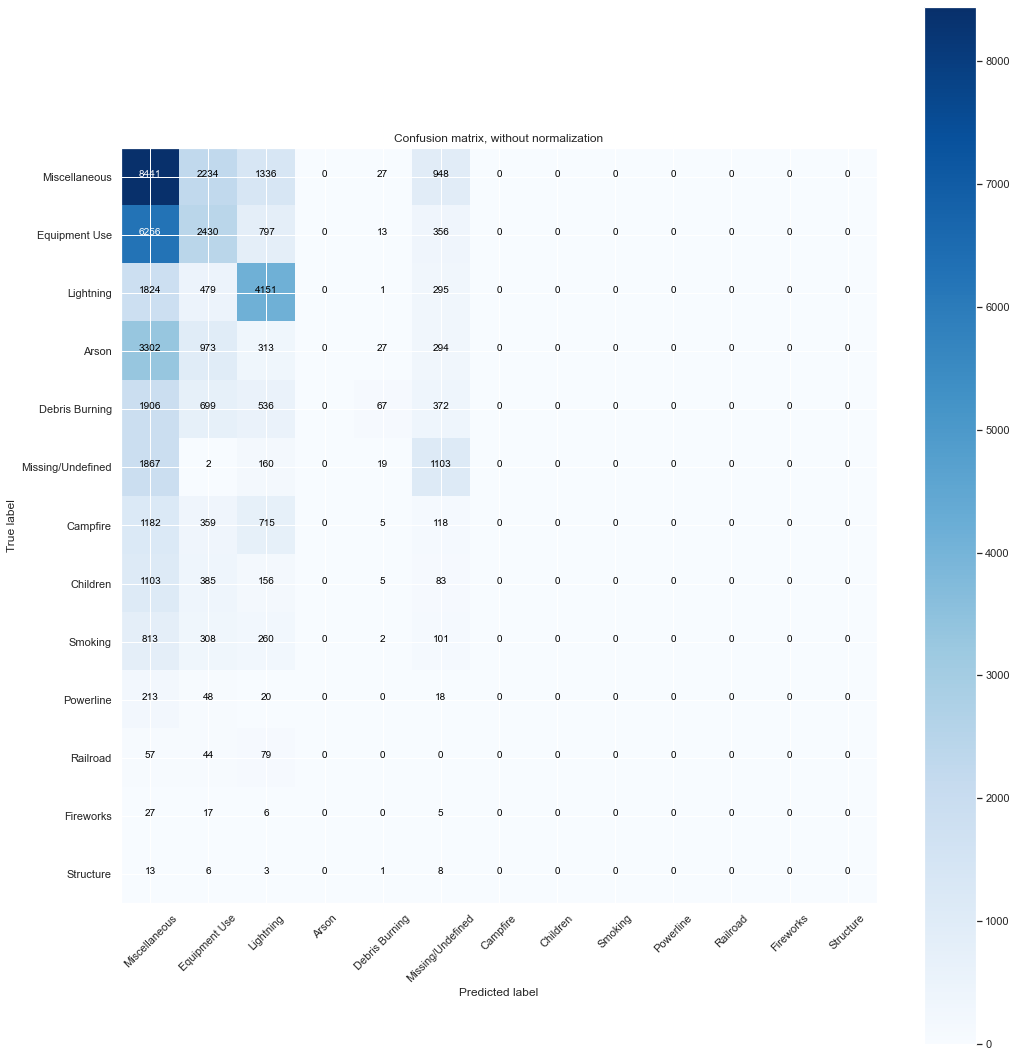

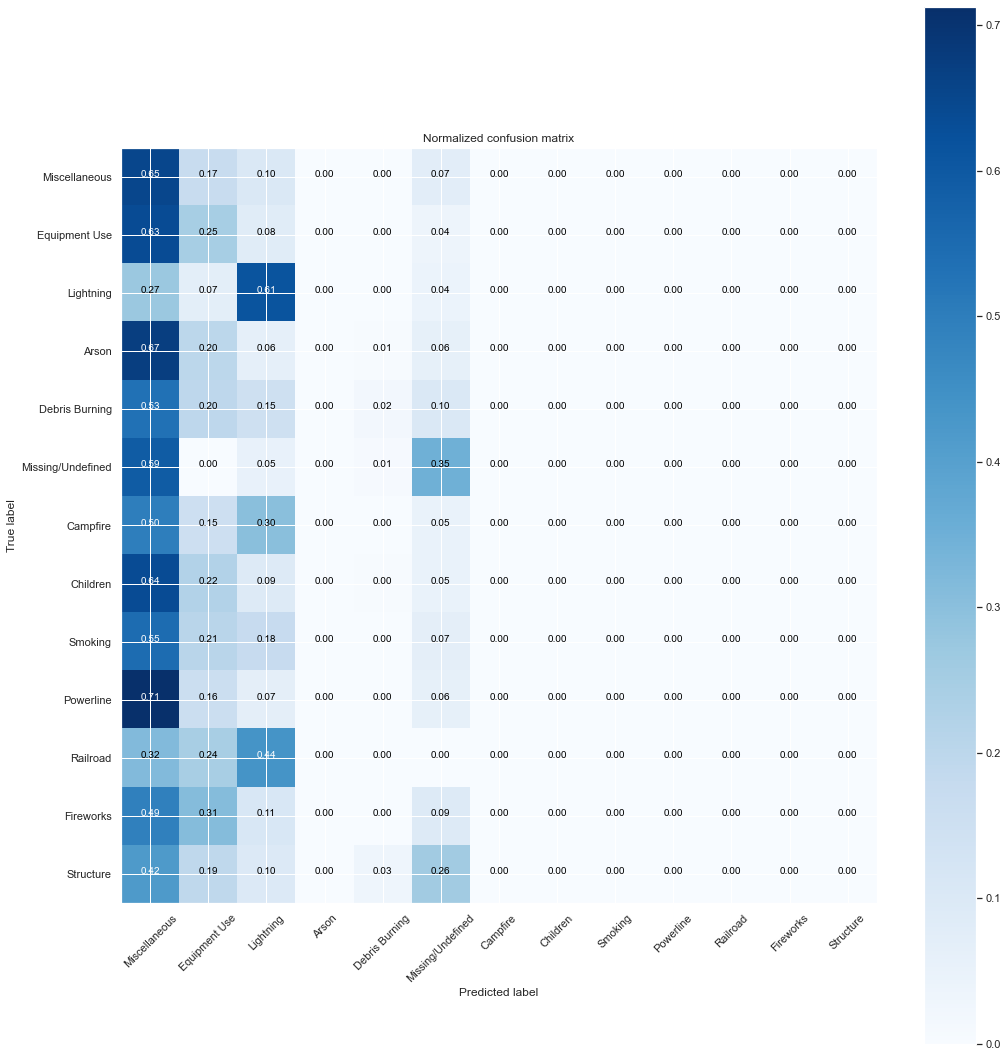

In [149]:
#Without Normalization
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes= ['Miscellaneous', 'Equipment Use', 'Lightning', 'Arson',
       'Debris Burning', 'Missing/Undefined', 'Campfire', 'Children',
       'Smoking', 'Powerline', 'Railroad', 'Fireworks', 'Structure'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes= ['Miscellaneous', 'Equipment Use', 'Lightning', 'Arson',
       'Debris Burning', 'Missing/Undefined', 'Campfire', 'Children',
       'Smoking', 'Powerline', 'Railroad', 'Fireworks', 'Structure'], normalize=True,
                      title='Normalized confusion matrix')

plt.show();

### Logistic Regression - 4 Classes

The following equation assigns the wildfire cause to a new, more generic label. 

In [87]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

df['label'] = df['stat_cause_descr'].apply(lambda x: set_label(x)) 

   nwcg_reporting_unit_name fire_name complex_name  fire_year  discovery_doy  \
0    Plumas National Forest  FOUNTAIN          NaN       2005             33   
1  Eldorado National Forest    PIGEON          NaN       2004            133   
2  Eldorado National Forest     SLACK          NaN       2004            152   
3  Eldorado National Forest      DEER          NaN       2004            180   
4  Eldorado National Forest  STEVENOT          NaN       2004            180   

   discovery_time stat_cause_descr  cont_doy  cont_time  fire_size  \
0          1300.0    Miscellaneous      33.0     1730.0       0.10   
1           845.0        Lightning     133.0     1530.0       0.25   
2          1921.0   Debris Burning     152.0     2024.0       0.10   
3          1600.0        Lightning     185.0     1400.0       0.10   
4          1600.0        Lightning     185.0     1200.0       0.10   

  fire_size_class   latitude   longitude state county discovery_date  \
0               A  40.0369

In [158]:
# Split into training & testing sets

X = df[features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [160]:
y_train.value_counts()

2    58775
4    48411
1    20250
3    14726
Name: label, dtype: int64

In [161]:
# Scaled X
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [162]:
# Instantiate the model
logr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Fit the model
model = logr.fit(X_train_sc, y_train.values.ravel())

# Accuracy Scores
score = model.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = model.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(logr, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(logr, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

Training Accuracy of Model is: 0.497080795149196
Testing Accuracy of Model is: 0.4960116485186123

Training Cross Val Score:  0.4970878297232478
Testing Cross Val Score:  0.4948510674425659


In [163]:
#Confusion Matrix
# Compute confusion matrix
y_predicted_labels = model.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 2967  2643     0  1140]
 [ 1452 12914     0  5226]
 [  139  3424     0  1346]
 [  873  7640     0  7624]]
Normalized confusion matrix
[[0.44 0.39 0.   0.17]
 [0.07 0.66 0.   0.27]
 [0.03 0.7  0.   0.27]
 [0.05 0.47 0.   0.47]]


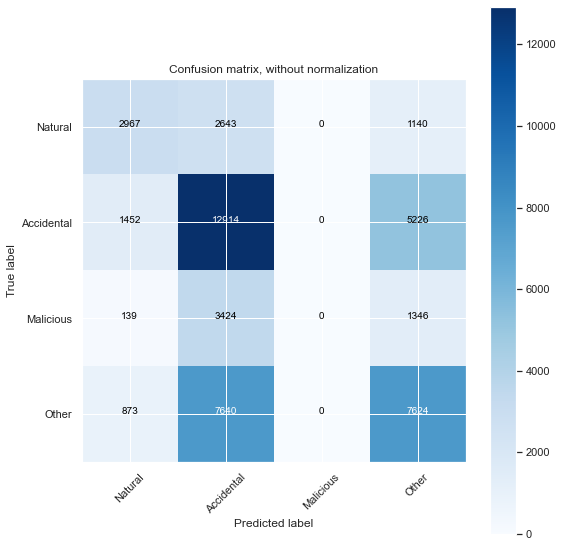

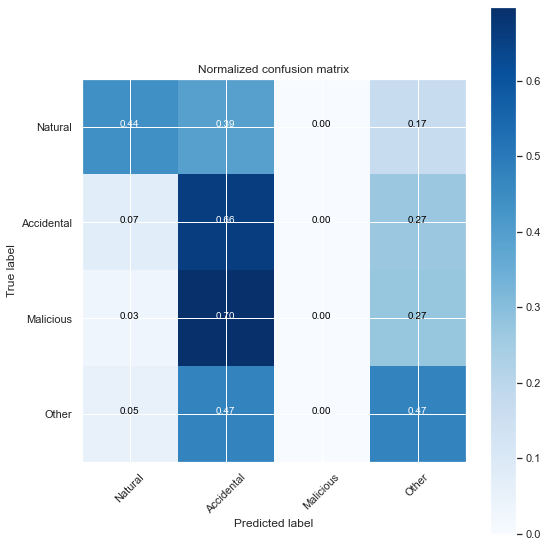

In [167]:
#Without Normalization
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes= ['Natural', 'Accidental', 'Malicious', 'Other'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes= ['Natural', 'Accidental', 'Malicious', 'Other'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# KNN

### Summary

The KNN model shows improvement over Logistic Regression. Following the same format as logistic regression, I tested the KNN model on 13 classes and 4 classes. The table below shows the scores from the models.

| Model            | Baseline Score | Accuracy Score - Train | Accuracy Score - Test | CrossValScore - Train | CrossValScore - Test |
|------------------|----------------|------------------------|-----------------------|-----------------------|----------------------|
| KNN - 13 Classes | 0.274          | 0.600                  | 0.420                 | 0.340                 | 0.344                |
| KNN - 4 Classes  | 0.413          | 0.683                  | 0.546                 | 0.497                 | 0.495                |

When considering the accuracy scores, both models appear to suffer from high variance bias, meaning the model is overfit to the training data and will not generalize to new data. The cross validation scores are much closer together but show a lower accuracy rate. The accuracy scores are better than the baseline but not by much. 

When evaluating 13 classes, the KNN model correctly predicted fires caused by lightning (80%), miscelaneous (52%), equipment use (38%) and arson (33%). This model does a much better job of predicting arson than the logistic regression even if it's only a 33% accuracy rate. When evaluating 4 classes, the KNN model correctly predicts natural (81%), accidental (62%), other (42%) and malicious (31%). The model's stregnth is predicting lighting fires. The model's weakness is predicting arson, which incorrectly is assigned to accidental 42% of the time. Similarily, 47% of other causes are also categorized as accidental.

### KNN - 13 Classes

In [169]:
# Split into training & testing sets

X = df[features]
y = df['stat_cause_descr_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [170]:
# Scaled X
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [171]:
# Instantiate the model
knn = KNeighborsClassifier()

# Fit the model
model = knn.fit(X_train_sc, y_train)

# Accuracy Scores
score = model.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = model.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(logr, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(logr, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

Training Accuracy of Model is: 0.579944007540693
Testing Accuracy of Model is: 0.42120368025660504

Training Cross Val Score:  0.33959849157971717
Testing Cross Val Score:  0.343504698562415


In [172]:
#Confusion Matrix
# Compute confusion matrix
y_predicted_labels = model.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[6809 3013  750  829  525  665  172  128   73   15    6    1    0]
 [4345 3701  410  517  273  351  103   69   60   10   13    0    0]
 [ 702  309 5429  107   49   37   81    7   22    5    0    2    0]
 [1610  943  213 1625  183  198   66   39   21    4    3    4    0]
 [1384  640  148  313  785  220   45   27   12    2    3    1    0]
 [1172  325  117  144  220 1106   22   21   21    2    0    1    0]
 [ 851  377  370  187   84   89  386   24    8    2    0    1    0]
 [ 861  402   88  111   68  110   28   43   17    3    1    0    0]
 [ 651  379  132  101   37  101   43   14   23    1    2    0    0]
 [ 117   81   16   12   18   29    3    2    1   20    0    0    0]
 [  60   45   23   11    6    1    0    1    3    0   30    0    0]
 [  19   13    4   10    0    3    0    2    1    0    0    3    0]
 [  10    2    5    6    4    2    1    0    0    1    0    0    0]]
Normalized confusion matrix
[[5.24e-01 2.32e-01 5.78e-02 6.38e-02 4.04e-02 

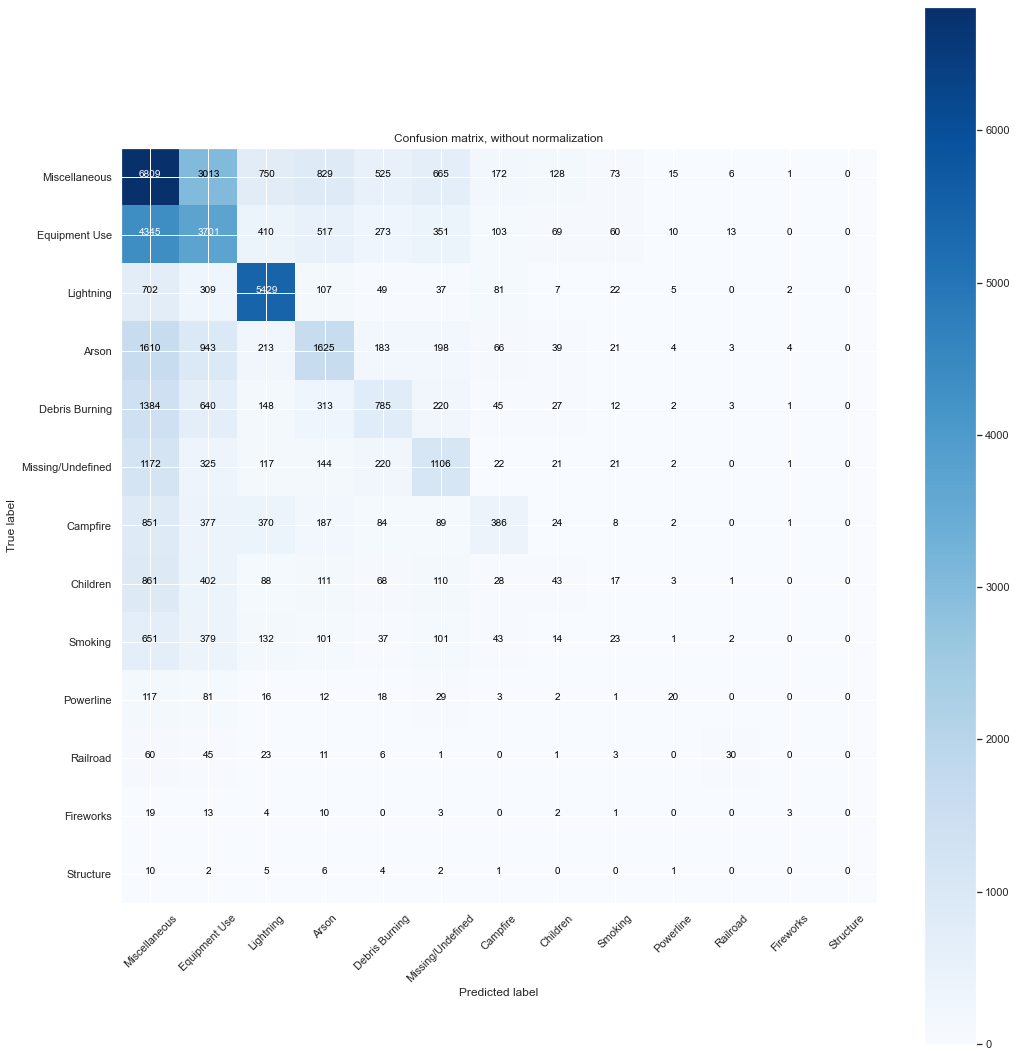

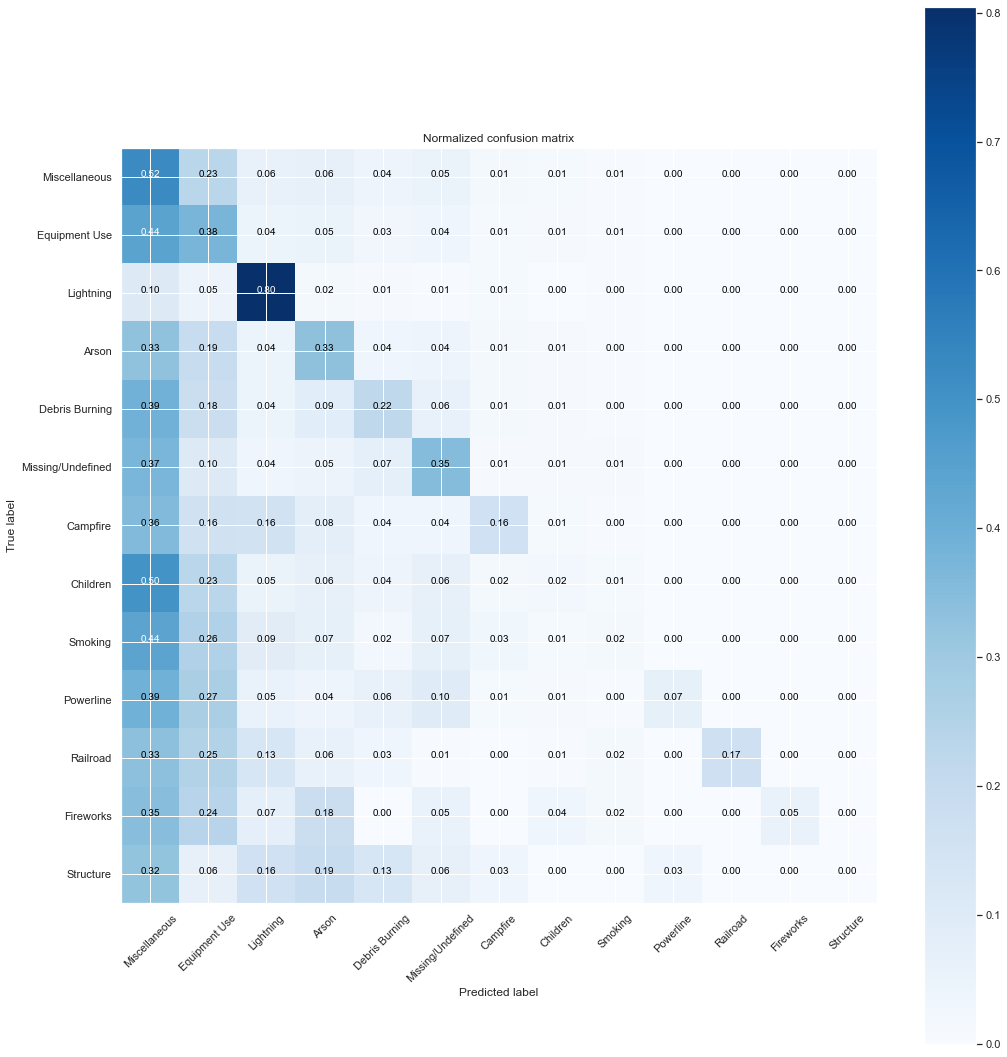

In [173]:
#Without Normalization
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes= ['Miscellaneous', 'Equipment Use', 'Lightning', 'Arson',
       'Debris Burning', 'Missing/Undefined', 'Campfire', 'Children',
       'Smoking', 'Powerline', 'Railroad', 'Fireworks', 'Structure'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes= ['Miscellaneous', 'Equipment Use', 'Lightning', 'Arson',
       'Debris Burning', 'Missing/Undefined', 'Campfire', 'Children',
       'Smoking', 'Powerline', 'Railroad', 'Fireworks', 'Structure'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### KNN - 4 Classes

In [179]:
# Split into training & testing sets

X = df[features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [180]:
# Scaled X
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [181]:
# Instantiate the model
knn = KNeighborsClassifier()

# Fit the model
model = knn.fit(X_train_sc, y_train)

# Accuracy Scores
score = model.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = model.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(logr, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(logr, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

Training Accuracy of Model is: 0.6832205512021496
Testing Accuracy of Model is: 0.5463619481725331

Training Cross Val Score:  0.4970878297232478
Testing Cross Val Score:  0.4948510674425659


In [182]:
#Confusion Matrix
# Compute confusion matrix
y_predicted_labels = model.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 5489   786    87   388]
 [ 1369 12071  1075  5077]
 [  209  2218  1503   979]
 [  971  7508   830  6828]]
Normalized confusion matrix
[[0.81 0.12 0.01 0.06]
 [0.07 0.62 0.05 0.26]
 [0.04 0.45 0.31 0.2 ]
 [0.06 0.47 0.05 0.42]]


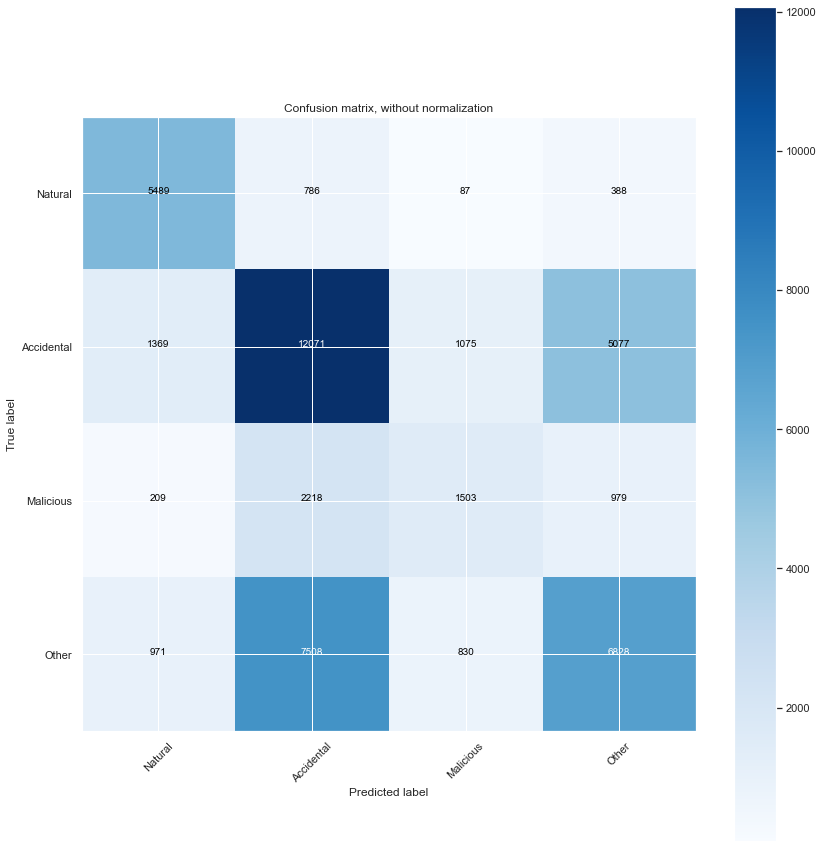

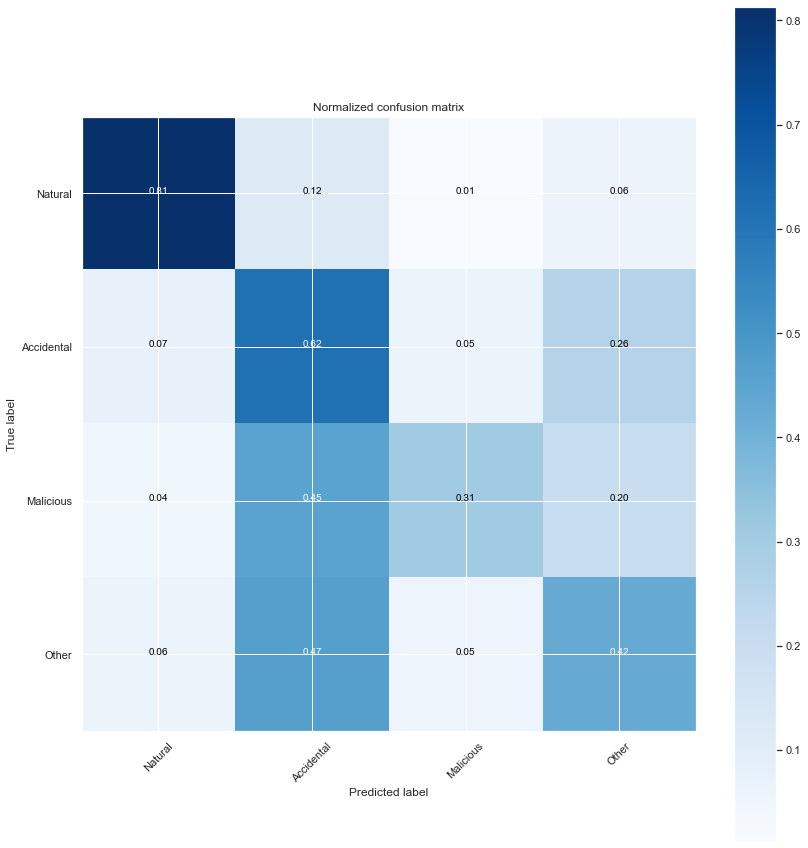

In [183]:
#Without Normalization
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cnf_matrix, classes= ['Natural', 'Accidental', 'Malicious', 'Other'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cnf_matrix, classes= ['Natural', 'Accidental', 'Malicious', 'Other'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Random Forest

### Summary

The Random Forest model shows improvement over Logistic Regression and KNN. Following the same format as before, I tested the Random Forest model on 13 classes and 4 classes. The table below shows the scores from the models.

| Model                      | Baseline Score | Accuracy Score - Train | Accuracy Score - Test | CrossValScore - Train | CrossValScore - Test |
|----------------------------|----------------|------------------------|-----------------------|-----------------------|----------------------|
| Random Forest - 13 Classes | 0.274          | 0.999                  | 0.489                 | 0.483                 | 0.457                |
| Random Forest - 4 Classes  | 0.413          | 0.999                  | 0.614                 | 0.607                 | 0.582                |              |

When considering the accuracy scores, both models appear to suffer from high variance bias, meaning the model is overfit to the training data and will not generalize to new data. The training data has a virtually perfect score while the testing score is at least 40 percentage points lower. The cross validation scores are much closer together and show a lower, and most likely more correct, accuracy rate. The accuracy scores beat the baseline better than the other two models. The 4 class Random Forest appears to be the winning model with a cross validated score of about 60%.

The confusion matrix reveals what we sacrifice for a higher score. The model predicts that all wildfires are caused by "other". This approach does not make the model useful. 

### Random Forest - 13 Classes

Confusion matrix, without normalization
[[   14     0     0    14     0 12958     0     0     0     0     0     0
      0]
 [    5     0     0     4     0  9843     0     0     0     0     0     0
      0]
 [    0     0     0     0     0  6750     0     0     0     0     0     0
      0]
 [    4     0     0     3     0  4902     0     0     0     0     0     0
      0]
 [    1     0     0    10     0  3569     0     0     0     0     0     0
      0]
 [    3     0     0    10     0  3138     0     0     0     0     0     0
      0]
 [    1     0     0     1     0  2377     0     0     0     0     0     0
      0]
 [    0     0     0     2     0  1730     0     0     0     0     0     0
      0]
 [    1     0     0     1     0  1482     0     0     0     0     0     0
      0]
 [    0     0     0     1     0   298     0     0     0     0     0     0
      0]
 [    0     0     0     1     0   179     0     0     0     0     0     0
      0]
 [    0     0     0     0     0    55     0    

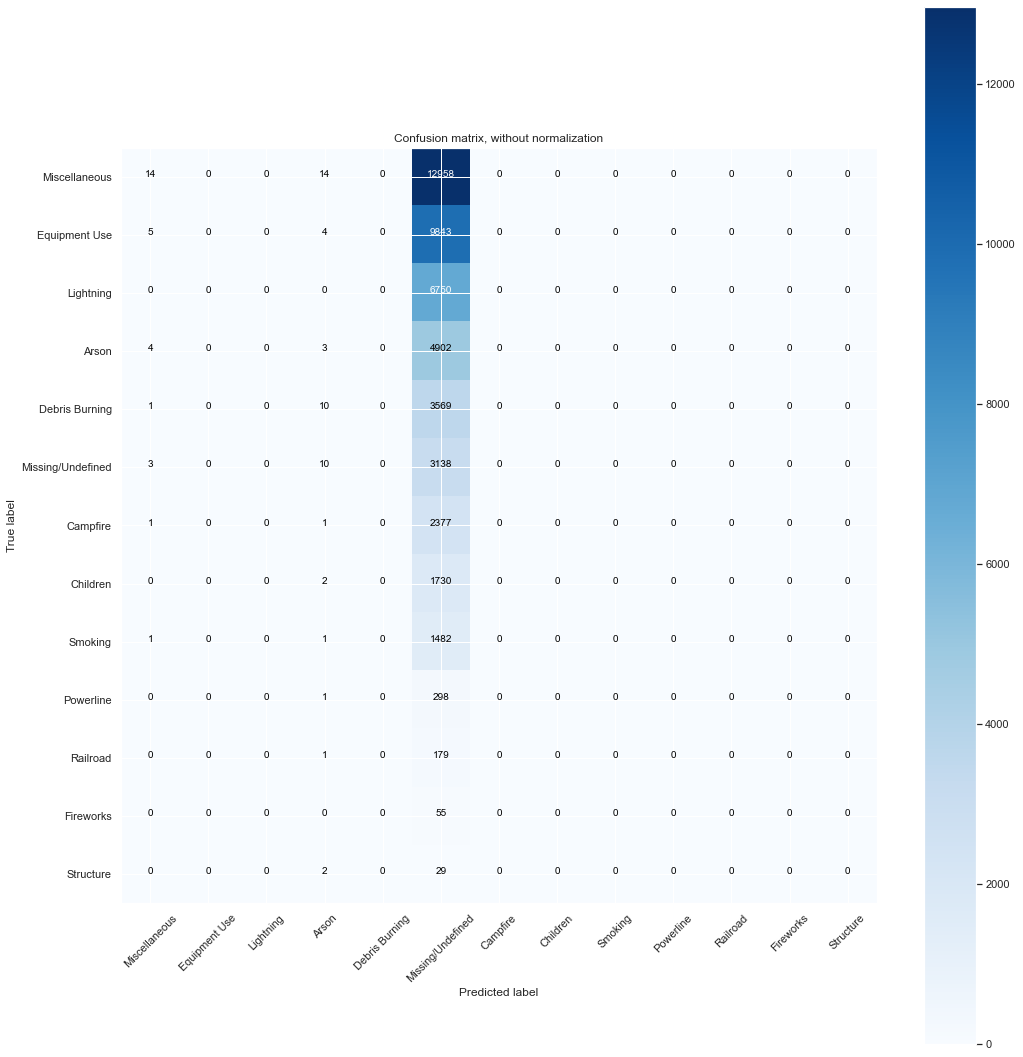

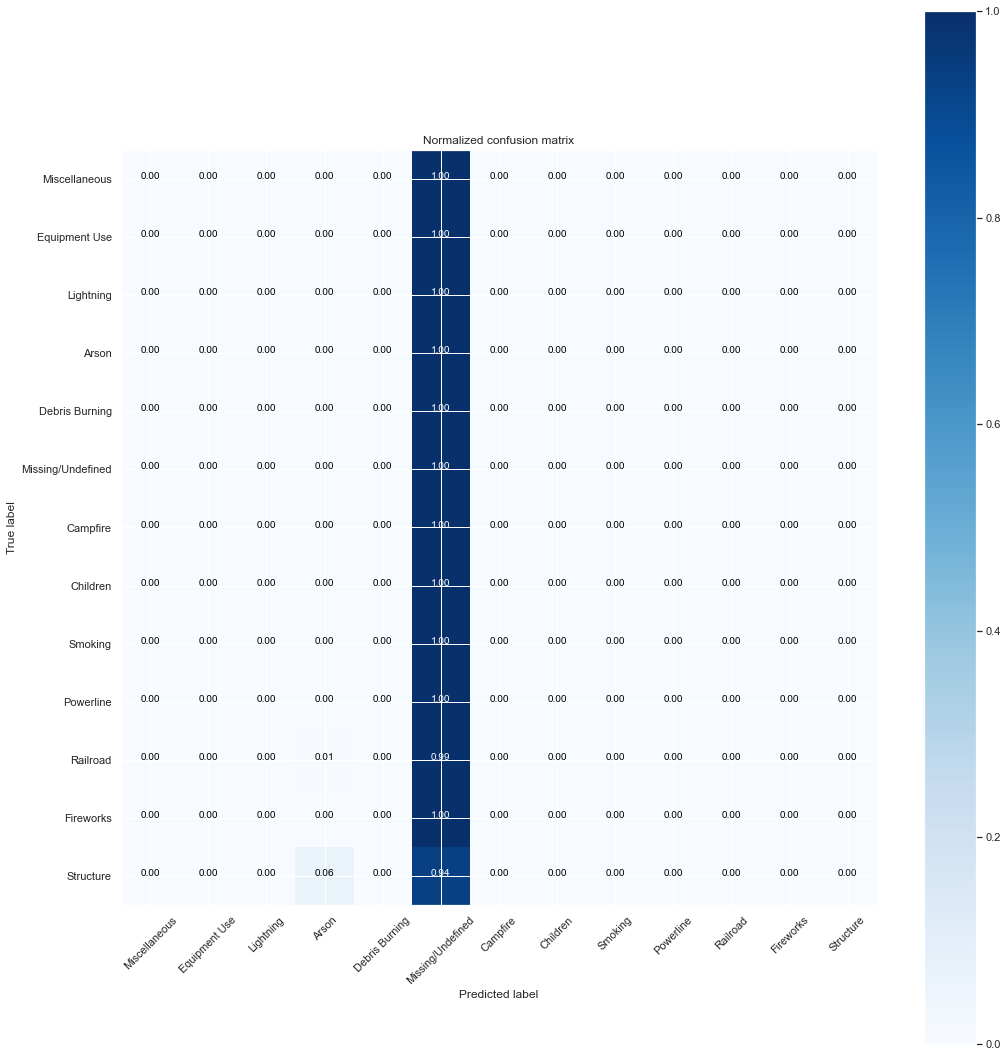

In [189]:
# Split into training & testing sets

X = df[features]
y = df['stat_cause_descr_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)


# Scaled X
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# Instantiate the model
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

# Fit the model
rf_model = rf.fit(X_train_sc, y_train)

# Confusion Matrix
# Compute confusion matrix
y_predicted_labels = rf_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)

#Without Normalization
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes= ['Miscellaneous', 'Equipment Use', 'Lightning', 'Arson',
       'Debris Burning', 'Missing/Undefined', 'Campfire', 'Children',
       'Smoking', 'Powerline', 'Railroad', 'Fireworks', 'Structure'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes= ['Miscellaneous', 'Equipment Use', 'Lightning', 'Arson',
       'Debris Burning', 'Missing/Undefined', 'Campfire', 'Children',
       'Smoking', 'Powerline', 'Railroad', 'Fireworks', 'Structure'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# code --> https://www.kaggle.com/sauravmaheshkar/fake-news-classification-using-random-forest

In [140]:
# Accuracy Scores
score = rf_model.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = rf_model.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(rf, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(rf, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

Training Accuracy of Model is: 0.9992684402301599
Testing Accuracy of Model is: 0.48942770321600404


### Random Forest - 4 Classes

Confusion matrix, without normalization
[[    0     0     0  6750]
 [    0     0     0 19592]
 [    0     0     0  4909]
 [    0     0     0 16137]]
Normalized confusion matrix
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


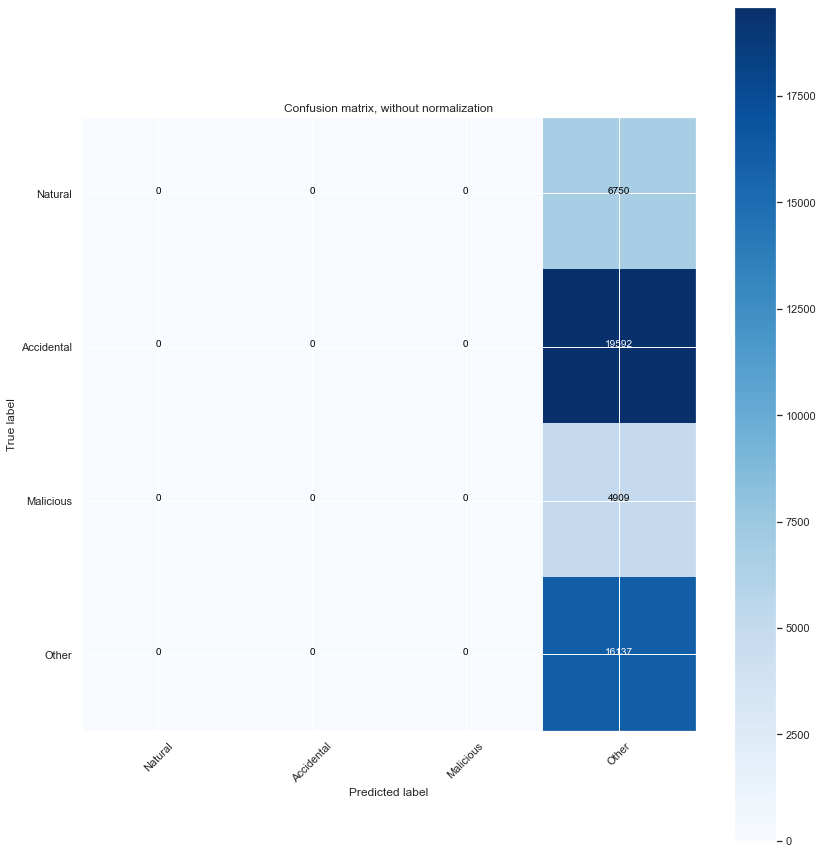

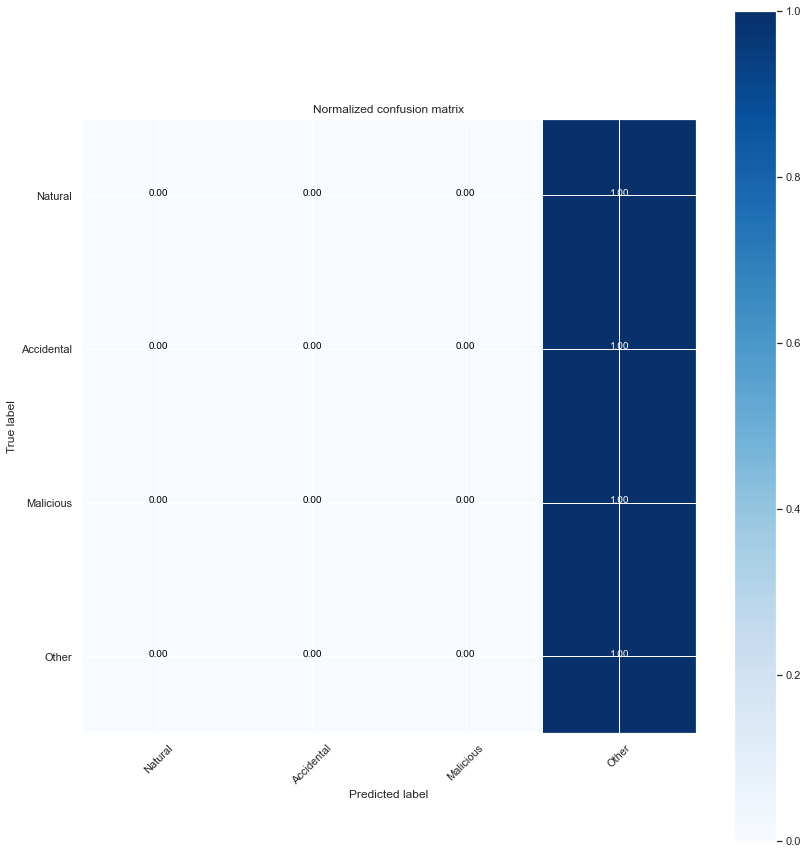

In [190]:
# Split into training & testing sets

X = df[features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)


# Scaled X
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# Instantiate the model
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

# Fit the model
rf_model = rf.fit(X_train_sc, y_train)

# Confusion Matrix
# Compute confusion matrix
y_predicted_labels = rf_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)
# cnf_matrix

#Without Normalization
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cnf_matrix, classes= ['Natural', 'Accidental', 'Malicious', 'Other'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cnf_matrix, classes= ['Natural', 'Accidental', 'Malicious', 'Other'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# code --> https://www.kaggle.com/sauravmaheshkar/fake-news-classification-using-random-forest

In [186]:
# Accuracy Scores
score = rf_model.score(X_train_sc, y_train)
print(f'Training Accuracy of Model is: {score}')

score = rf_model.score(X_test_sc, y_test)
print(f'Testing Accuracy of Model is: {score}')

# Cross Val Scores
print()
print('Training Cross Val Score: ', cross_val_score(rf, X_train_sc, y_train, cv = 5, n_jobs = -1).mean())
print('Testing Cross Val Score: ', cross_val_score(rf, X_test_sc, y_test, cv = 5, n_jobs = -1).mean())

Training Accuracy of Model is: 0.9993458167442777
Testing Accuracy of Model is: 0.6128977800286992


# Recommended Use

Though the Random Forest model was the most accurate it comes at a great cost. It predicts that every fire is caused by "other", which incorrectly predicts every other category. 

The best model is this one because these reasons.



Thus in order to demonstrate our recommended use for such a model, we utilized our logistic regression model to simulate what we think are more realistic results.
Below, we created a function that would take two thresholds to create a third classification: "Unsure". This is so any manual fact-checking that needs to be done can be applied only to the articles that might actually be true. Articles with very high likelihoods of falsity will be classified as such so that fact-checkers can focus their efforts on articles that are harder to classify confidently. Our recommendation is that platforms determine their thresholds based on whether they are trying to optimize for overall accuracy, sensitivity, specificity, or the least possible manual fact-checking. See our experiments below to get a sense of how this could work.

| Model            | Baseline Score | Accuracy Score - Train | Accuracy Score - Test | CrossValScore - Train | CrossValScore - Test |
|------------------|----------------|------------------------|-----------------------|-----------------------|----------------------|
| Logistic Regression - 13 Classes | 0.274          | 0.340                  | 0.342                 | 0.340                 | 0.344                |
| Logistic Regression - 4 Classes  | 0.413          | 0.500                  | 0.500                 | 0.500                 | 0.495 
| KNN - 13 Classes | 0.274          | 0.600                  | 0.420                 | 0.340                 | 0.344                |
| KNN - 4 Classes  | 0.413          | 0.683                  | 0.546                 | 0.497                 | 0.495                |
| Random Forest - 13 Classes | 0.274          | 0.999                  | 0.489                 | 0.483                 | 0.457                |
| Random Forest - 4 Classes  | 0.413          | 0.999                  | 0.614                 | 0.607                 | 0.582                |

data sources:

In [ ]:
# https://www.kaggle.com/edhirif/predict-the-causes-of-wildfires-using-python

In [ ]:
fires.FIRE_SIZE_CLASS.value_counts()

In [ ]:
# https://www.kaggle.com/captcalculator/can-we-use-ml-to-predict-the-cause-of-a-wildfire